In [1]:
%pylab inline

import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
import datetime as dt
import dateutil.parser
import matplotlib.mlab as ml
from mpl_toolkits.axes_grid1 import make_axes_locatable

Populating the interactive namespace from numpy and matplotlib


In [2]:
def convert(date):
    dt = dateutil.parser.parse(date).replace(tzinfo=None)
    epoch = dt.utcfromtimestamp(0)
    delta = dt - epoch
    return delta.total_seconds()

In [23]:
path = "/Users/aRa/OneDrive/Documentos/ERASMUS/PFC/SmartCoach/Running_w_HR/APE_runs_oct26-mar22"
window_size_half = 3
colnames = np.array(['time', 'elevation', 'distance', 'speed', 'HR'])
Datasets_all = []
os.chdir(path)
for file in glob.glob("*.tab"):
    ds = np.genfromtxt(file, skip_header=1, delimiter='\t', converters={0: convert})
    ds[:,0] -= ds[0,0]                              # time reference set to 0
          
#    if (ds[:,2].max() > 10000) == (ds[:,2].max() < 13000):
    ds = pd.DataFrame(ds,columns=colnames)
    slope = np.array([])
    pace = []

    for i in ds.index:
        index = np.arange(i - window_size_half + 1, i + window_size_half + 1)
        index = index[(index >= 0) & (index < len(ds))]
        dataset_part = ds[['distance','elevation']].iloc[index].dropna()

        regr = lm.LinearRegression()
        regr.fit(dataset_part.distance[:,np.newaxis], np.array(dataset_part.elevation))

        slope = np.append(slope,regr.coef_)

    dataset_new = ds.drop(['elevation'], axis=1)
    dataset_new['slope'] = slope

    Datasets_all.append(dataset_new)
len(Datasets_all)

14

In [24]:
#RECALCULO DE LA VELOCIDAD PARA LA ACTIVITY_634112810
if len(Datasets_all) > 7:
    distances = np.array(Datasets_all[2].distance)
    times = np.array(Datasets_all[2].time)
    distance_diffs = np.concatenate([[distances[0]], distances[1:] - distances[:-1]])
    time_diffs = np.concatenate([[times[0]], times[1:] - times[:-1]])
    Datasets_all[2].speed = distance_diffs / time_diffs
    Datasets_all[2].replace(np.inf, np.nan, inplace=True)

In [25]:
slope_min = -0.2                              #slope
slope_max = 0.2                               #slope
speed_min = 0                                 #speed
speed_max = 5                                 #speed
res = 20
distance_step = 100

In [6]:
def cut(data, res, x_min, x_max, y_min, y_max):
    bins = [np.linspace(x_min, x_max, res+1), np.linspace(y_min, y_max,res+1)]
    x_low_edges = np.array([])
    x_high_edges = np.array([])
    y_low_edges = np.array([])
    y_high_edges = np.array([])
    
    for i in range(res):
        x_low_edges = np.append(x_low_edges, bins[0][i])
        x_high_edges = np.append(x_high_edges, bins[0][i+1])
        y_low_edges = np.append(y_low_edges, bins[1][i])
        y_high_edges = np.append(y_high_edges, bins[1][i+1])
    
    x_intervals = np.array([x_low_edges, x_high_edges])
    x_mids = x_intervals.mean(0)
    y_intervals = np.array([y_low_edges, y_high_edges])
    y_mids = y_intervals.mean(0)

    table_indices = []
    for i in np.arange(res):
        for j in np.arange(res):
            temp = data.index[(data.icol(0) > x_intervals[0][i]) 
                            & (data.icol(0) <= x_intervals[1][i])]    
            table_indices.append(np.array(data.index[(np.array(data.icol(2).loc[temp]) > y_intervals[0][j]) 
                                                   & (np.array(data.icol(2).loc[temp]) <= y_intervals[1][j])]))
    
    table_indices = np.reshape(table_indices, (res,res))
    
    return [table_indices, x_intervals, x_mids, y_intervals, y_mids]

In [7]:
def profile3D(data_in, res, xmin, xmax, ymin, ymax):
    table, x_intervals, x_mids, y_intervals, y_mids = cut(data_in, res, xmin, xmax, ymin, ymax)
    (x,y) = np.shape(table)
    means = np.array([])
    stds = np.array([])
    counts = np.array([])
    
    for i in np.arange(x):
        for j in np.arange(y):
            means = np.append(np.nanmean(data_in.icol(1).iloc[table[i,j]]), means)
            stds = np.append(np.nanstd(data_in.icol(1).iloc[table[i,j]]), stds)
            counts = np.append(len(table[i,j]), counts)

    rows = [str((round(x_intervals[0,i],2), round(x_intervals[1,i],2))) for i in np.arange(res)]
    cols = [str((round(y_intervals[0,i],2), round(y_intervals[1,i],2))) for i in np.arange(res)]
    
    means = pd.DataFrame(means.reshape((res,res)), index=rows, columns=cols)
    stds = pd.DataFrame(stds.reshape((res,res)), index=rows, columns=cols)
    counts = pd.DataFrame(counts.reshape((res,res)), index=rows, columns=cols)

    return [table, means, stds, counts, x_intervals, x_mids, y_intervals, y_mids]

In [8]:
def profile3D_2(trained_data):
    X = trained_data.speed
    Y = trained_data.slope
    Z = trained_data.HR

    xmin = X.min()
    xmax = X.max()
    ymin = Y.min()
    ymax = Y.max()

    binsize = 0.1
    bins = 20

    xx = np.linspace(xmin, xmax, bins)
    yy = np.linspace(ymin, ymax, bins)
    zz = pd.DataFrame(ml.griddata(X, Y, Z, xx, yy, interp='nn'),index=xx, columns=yy)
    
    return [xx, yy, zz]

In [26]:
training_data = pd.concat(Datasets_all,ignore_index=True)
training_data_filtered = training_data[(training_data.slope < slope_max)
                                       &(training_data.slope > slope_min)
                                       &(training_data.speed > speed_min)
                                       &(training_data.speed < speed_max)].drop(['time','distance'],axis=1)

current_profile = profile3D(training_data_filtered, res, speed_min, speed_max, slope_min, slope_max)
current_profile2 = profile3D_2(training_data_filtered)

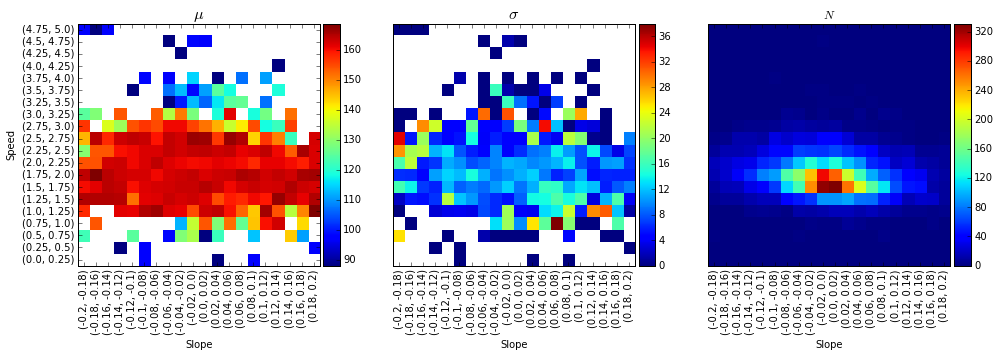

In [27]:
# HEATMAP METHOD1    
x_lim = [current_profile[6].min(), current_profile[6].max()]
y_lim = [current_profile[4].min(), current_profile[4].max()]

x_tck_lbl = [str((round(current_profile[6][0,i],2), round(current_profile[6][1,i],2))) for i in np.arange(res)]
y_tck_lbl = [str((round(current_profile[4][0,i],2), round(current_profile[4][1,i],2))) for i in np.arange(res)]

x_tck = range(current_profile[1].shape[0])
y_tck = range(current_profile[1].shape[1])


fig = plt.figure(figsize=(16,5), dpi=72)
ax1 = fig.add_subplot(131)
#im1 = ax1.imshow(current_profile[1].mask(current_profile[3] < 10), origin='lower', interpolation='nearest')
im1 = ax1.imshow(current_profile[1], origin='lower', interpolation='nearest')
plt.xticks(x_tck, x_tck_lbl, rotation='vertical')
plt.yticks(y_tck, y_tck_lbl)
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="7%", pad=0.05)
cbar1 = plt.colorbar(im1, cax=cax1)
ax1.set_title(r'$\mu$',fontsize=16)
ax1.set_xlabel('Slope')
ax1.set_ylabel('Speed')

ax2 = fig.add_subplot(132)
#im2 = ax2.imshow(current_profile[2].mask(current_profile[3] < 10), origin='lower', interpolation='nearest')
im2 = ax2.imshow(current_profile[2], origin='lower', interpolation='nearest')
plt.xticks(x_tck, x_tck_lbl, rotation='vertical')
ax2.set_yticks([])
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="7%", pad=0.05)
cbar2 = plt.colorbar(im2, cax=cax2)
ax2.set_title(r'$\sigma$',fontsize=16)
ax2.set_xlabel('Slope')

ax3 = fig.add_subplot(133)
#im3 = ax3.imshow(current_profile[3].mask(current_profile[3] < 10), origin='lower', interpolation='nearest')
im3 = ax3.imshow(current_profile[3], origin='lower', interpolation='nearest')
plt.xticks(x_tck, x_tck_lbl, rotation='vertical')
ax3.set_yticks([])
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes("right", size="7%", pad=0.05)
cbar3 = plt.colorbar(im3, cax=cax3)
ax3.set_title(r'$N$')
ax3.set_xlabel('Slope')

plt.show()
#if len(Datasets_all) == 7: 
#    fig.savefig('../../../Thesis/images/heatmapCS6Method1_FilteredRuns.pdf', bbox_inches='tight', dpi=fig.dpi)
#else:
#    fig.savefig('../../../Thesis/images/heatmapCS6Method1_AllRuns.pdf', bbox_inches='tight', dpi=fig.dpi)

<matplotlib.colorbar.Colorbar instance at 0x10b52e488>

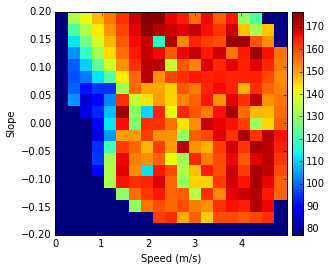

In [28]:
zmin = np.array(current_profile2[2])[np.where(np.isnan(current_profile2[2]) == False)].min()
zmax = np.array(current_profile2[2])[np.where(np.isnan(current_profile2[2]) == False)].max()

fig = plt.figure(figsize=(5,4))
plt.pcolormesh(current_profile2[0], current_profile2[1], np.array(current_profile2[2]),
               cmap=plt.cm.jet, vmin=zmin, vmax=zmax)
plt.xlim([0., current_profile2[0].max()])
plt.ylim([-0.2, 0.2])
plt.yticks()
plt.xlabel('Speed (m/s)')
plt.ylabel('Slope')
plt.colorbar(pad=0.02)
#if len(Datasets_all) == 7:
#    fig.savefig('../../../Thesis/images/heatmapHRgriddataFilterRuns.pdf', bbox_inches='tight')
#else:
#    fig.savefig('../../../Thesis/images/heatmapHRgriddataAllRuns.pdf', bbox_inches='tight')

In [12]:
def HRF_predictor(trained_data, trained_data_HR, validation_data):
    hrf_predicted = []

    for i in validation_data.index:
        sp = validation_data.speed.iloc [i]
        sl = validation_data.slope.iloc[i]
        hr = validation_data.HR.iloc[i]

        sp_index = np.flatnonzero((trained_data[4][0] < sp) == (sp <= trained_data[4][1]))
        sl_index = np.flatnonzero((trained_data[6][0] < sl) == (sl <= trained_data[6][1]))

        if len(sl_index) == 0:
            if sl <= trained_data[6][0,0]:
                sl_index = np.array([0])
            elif sl > trained_data[6][1,res-1]:
                sl_index = np.array([res-1])

        if len(sp_index) == 0:
            if sp <= trained_data[4][0,0]:
                sp_index = np.array([0])
            elif sp > trained_data[4][1,res-1]:
                sl_index = np.array([res-1])      

        hrf_predicted.append(np.array(trained_data_HR)[sp_index,sl_index])
#    prediction_error = abs(np.ravel(hrf_predicted) - np.array(validation_data.HR))
    prediction_error = np.ravel(hrf_predicted) - np.array(validation_data.HR)
    relative_prediction_error = prediction_error / np.array(validation_data.HR)
    return [np.ravel(hrf_predicted), prediction_error]

In [29]:
path = "/Users/aRa/OneDrive/Documentos/ERASMUS/PFC/SmartCoach/Running_w_HR/TEST"
os.chdir(path)
file = "feeling_bad_activity.tab"

dataset = np.genfromtxt(file, skip_header=1,delimiter='\t', converters={0: convert})
dataset[:,0] -= dataset[0,0]
dataset = pd.DataFrame(dataset,columns=colnames)
slope = np.array([])
dHR = np.array([])

for i in dataset.index:
    index = np.arange(i-window_size_half+1, i+window_size_half+1)
    index = index[(index >= 0) & (index < len(dataset))]
    dataset_part = dataset.iloc[index].dropna()
    regr = lm.LinearRegression()
    regr.fit(dataset_part.distance[:,np.newaxis], np.array(dataset_part.elevation))
    slope = np.append(slope,regr.coef_)
    dHR = np.append(dHR,(dataset.HR.iloc[index[-1]] - dataset.HR.iloc[index[0]]))

validation_data = pd.concat([dataset.dropna(), pd.DataFrame(slope,columns=['slope']).dropna(),
                            pd.DataFrame(dHR,columns=['dHR']).dropna()], axis=1)

distances = np.array(validation_data.distance)
distance_diffs = np.concatenate([[distances[0]], distances[1:] - distances[:len(distances)-1]])

predictedHR1 = HRF_predictor(current_profile, current_profile[1], validation_data)
predictedHR2 = HRF_predictor(current_profile, current_profile2[2], validation_data)

predictedsHR = []
#if file == 'feeling_bad_activity.tab':
#    np.savez('predictedHRFeelingBad', predictedHR1=predictedHR1, predictedHR2=predictedHR2)
#elif file == 'Morat_Fribourg2014.tab':
#    np.savez('predictedHRMorFrib', predictedHR1=predictedHR1, predictedHR2=predictedHR2)
#elif file == 'test_activity.tab':
#    np.savez('predictedHRTest', predictedHR1=predictedHR1, predictedHR2=predictedHR2)

In [30]:
print '{}'.format(file[:-4])
print 'Metodo 1: Encontrados {0} de {1} = {2:.2f}%'.format((predictedHR1[1].size - np.isnan(predictedHR1[1]).sum()), 
                                                         predictedHR1[1].size, 
                                                         (predictedHR1[1].size - np.isnan(predictedHR1[1]).sum())/float(predictedHR1[1].size)*100)
print 'Metodo 2: Encontrados {0} de {1} = {2:.2f}%'.format((predictedHR2[1].size - np.isnan(predictedHR2[1]).sum()), 
                                                         predictedHR2[1].size, 
                                                         (predictedHR2[1].size - np.isnan(predictedHR2[1]).sum())/float(predictedHR2[1].size)*100)

feeling_bad_activity
Metodo 1: Encontrados 361 de 506 = 71.34%
Metodo 2: Encontrados 453 de 506 = 89.53%


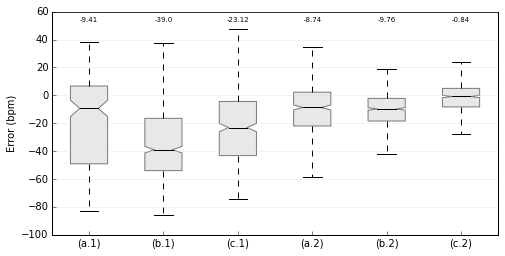

In [31]:
# BOXPLOT HRF PREDICTION ERRORS
predictedHRFeelingBad = np.load('predictedHRFeelingBad.npz')
predictedHRMorFrib = np.load('predictedHRMorFrib.npz')
predictedHRTest = np.load('predictedHRTest.npz')

data = [predictedHRFeelingBad['predictedHR1'][1][~np.isnan(predictedHRFeelingBad['predictedHR1'][1])],
        predictedHRMorFrib['predictedHR1'][1][~np.isnan(predictedHRMorFrib['predictedHR1'][1])],
        predictedHRTest['predictedHR1'][1][~np.isnan(predictedHRTest['predictedHR1'][1])],
        predictedHRFeelingBad['predictedHR2'][1][~np.isnan(predictedHRFeelingBad['predictedHR2'][1])],
        predictedHRMorFrib['predictedHR2'][1][~np.isnan(predictedHRMorFrib['predictedHR2'][1])],
        predictedHRTest['predictedHR2'][1][~np.isnan(predictedHRTest['predictedHR2'][1])]]

numBoxes = len(data)
pos = np.arange(numBoxes)+1

fig = plt.figure(figsize=(8,4), dpi=72)
ax = fig.add_subplot(111)
bp = ax.boxplot(data, labels=['(a.1)', '(b.1)', '(c.1)', '(a.2)', '(b.2)', '(c.2)'], patch_artist=True, sym='', notch=True)

plt.setp(bp['boxes'], color='black', facecolor = 'lightgrey', alpha=0.5)
plt.setp(bp['medians'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['caps'], color='black')

medians = [np.nanmedian(i) for i in data]
pos = np.arange(numBoxes)+1
upperLabels = [str(np.round(s, 2)) for s in medians]

# Set the axes ranges and axes labels
ax.set_ylim([-100, 60])
top = ax.get_ylim()[1]*0.88

for tick,label in zip(range(numBoxes),ax.get_xticklabels()):
    ax.text(pos[tick], top, upperLabels[tick], horizontalalignment='center', size='x-small', color='black')

ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.set_ylabel('Error (bpm)')

#if len(Datasets_all) == 7:
#    fig.savefig('../../../Thesis/images/bxplotErrorPredictionHRFiltered.pdf',bbox_inches='tight', dpi=fig.dpi)
#else:
#    fig.savefig('../../../Thesis/images/bxplotErrorPredictionHRAll.pdf',bbox_inches='tight', dpi=fig.dpi)

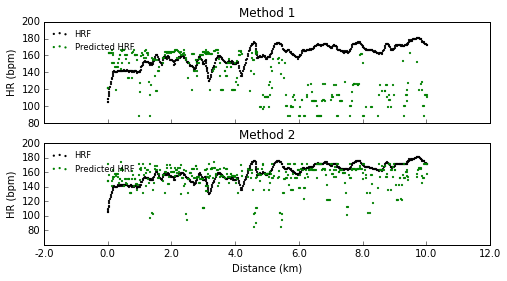

In [32]:
# COMPARISON PREDICTION METHODS
fig = plt.figure(figsize=(8,4), dpi=72)
ax1 = plt.subplot(211)
ax1.scatter(validation_data.distance, validation_data.HR, marker='.' ,c='k', linewidths=0, label='HRF')
ax1.scatter(validation_data.distance, predictedHR1[0], marker='.', c='g', linewidths=0, label='Predicted HRF')
ax1.set_title('Method 1')
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = plt.subplot(212)
ax2.scatter(validation_data.distance, validation_data.HR, marker='.', c='k', linewidths=0, label='HRF')
ax2.scatter(validation_data.distance, predictedHR2[0],marker='.', c='g', linewidths=0, label='Predicted HRF')
ax2.set_title('Method 2')
ax2.set_xticklabels([np.str(i/1000) for i in ax2.get_xticks()])
ax2.set_xlabel('Distance (km)')
for ax in [ax1 , ax2]:
    ax.set_yticks([  80.,  100.,  120.,  140.,  160.,  180.,  200.])
    ax.set_ylabel('HR (bpm)')
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.legend(loc=2,fontsize='small', frameon=False)

#if len(Datasets_all) == 7:
#    if file == 'feeling_bad_activity.tab':
#        fig.savefig('../../../Thesis/images/predictionFeelingBadHRFilterRuns.pdf',bbox_inches='tight', dpi=fig.dpi)
#    elif file == 'Morat_Fribourg2014.tab':
#        fig.savefig('../../../Thesis/images/predictionMoratFribHRFilterRuns.pdf',bbox_inches='tight', dpi=fig.dpi)
#    elif file == 'test_activity.tab.tab':
#        fig.savefig('../../../Thesis/images/predictionTestHRFilterRuns.pdf',bbox_inches='tight', dpi=fig.dpi)
#else:
#    if file == 'feeling_bad_activity.tab':
#        fig.savefig('../../../Thesis/images/predictionFeelingBadHRAllRuns.pdf',bbox_inches='tight', dpi=fig.dpi)
#    elif file == 'Morat_Fribourg2014.tab':
#        fig.savefig('../../../Thesis/images/predictionMoratFribHRAllRuns.pdf',bbox_inches='tight', dpi=fig.dpi)
#    elif file == 'test_activity.tab.tab':
#        fig.savefig('../../../Thesis/images/predictionTestHRAllRuns.pdf',bbox_inches='tight', dpi=fig.dpi)

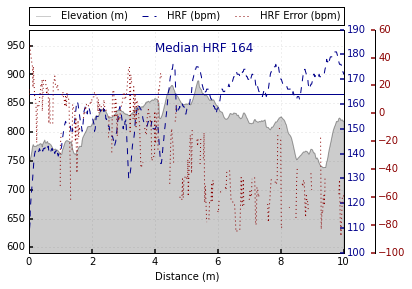

In [33]:
# ELEVATION, HRF & ESTIMATED HRF ERRROR
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.itervalues():
        sp.set_visible(False)
        
fig, host = plt.subplots(figsize=(7,4), dpi=72)
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

par2.spines["right"].set_position(("axes", 1.1))
make_patch_spines_invisible(par2)
par2.spines["right"].set_visible(True)

p1, = host.plot(distances, validation_data.elevation, color='k', label='Elevation (m)',alpha=0.2)
host.fill_between(distances, 0, validation_data.elevation, color='k', alpha=0.2)
p2, = par1.plot(distances, validation_data.HR, color='DarkBlue', linestyle='--', label='HRF (bpm)')
p2.axes.axhline(y= training_data.HR.median(), color='DarkBlue')
p3, = par2.plot(distances, predictedHR1[1], color='DarkRed', 
                linestyle=':', label='HRF Error (bpm)')

host.set_xlim([min(distances), max(distances)])
host.set_ylim([validation_data.elevation.min()*0.8, validation_data.elevation.max()*1.1])
host.set_xticklabels([np.str(int(i)) for i in host.get_xticks()/1000])

host.set_xlabel('Distance (m)')

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
host.tick_params(axis='x', **tkw)
host.get_xaxis().tick_bottom()

host.legend((p1, p2, p3),(p1.get_label(), p2.get_label(), p3.get_label()),
           bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.,
            fontsize=10)
host.grid(alpha=0.25)
host.text(0.4*host.get_xlim()[-1],0.96*host.get_ylim()[-1],
          'Median HRF {:.0f}'.format(training_data.HR.median()), color='DarkBlue', fontsize=12)
#fig.savefig("../../../Thesis/images/errorHRFCS6FeelingBad_Method1_All.pdf", bbox_inches='tight', dpi=fig.dpi)

In [34]:
# SPEED PREDICTOR 1
threshold = 5
sp_mids = pd.DataFrame(current_profile[5], index=current_profile[1].index, columns=['sp mids'])
predictedSp1 = []

for i in validation_data.index:
    sl = validation_data.slope.iloc[i]
    hr = validation_data.HR.iloc [i]
    sl_index = current_profile[1].columns[(current_profile[6][0] < sl) == (sl <= current_profile[6][1])]
    
    if len(sl_index) == 0:
        if sl <= current_profile[6][0,0]:
            sl_index = current_profile[1].columns[0]
        elif sl > current_profile[6][1,res-1]:
            sl_index = current_profile[1].columns[-1]
    sl_interval = current_profile[1][sl_index]

    # mirar las que estan por debajo del umbral
#    if ((np.abs(sl_interval - hr)).min() < threshold).any():
    
    # mirar las que NO se repiten
    if  not(len(np.where((abs(sl_interval - hr)) == np.nanmin(abs(sl_interval - hr)))[0]) > 1):
        sp_interval = (abs(sl_interval - hr)).idxmin()
        sp_interval_mean = sp_mids.loc[sp_interval]    
        predictedSp1.append(np.ravel(sp_interval_mean.values))
    # mirar las que SI se repetine
    else:
        predictedSp1.append(np.array([np.nan]))
        rep_index = np.where((abs(sl_interval - hr)) == np.nanmin(abs(sl_interval - hr)))[0]
#        print current_profile[1][sl_index].iloc[rep_index]
#        print current_profile[2][sl_index].iloc[rep_index]
#        print current_profile[3][sl_index].iloc[rep_index]

In [35]:
# SPEED PREDICTOR 2
predictedSp2 = []
for i in validation_data.index:
    sl = validation_data.slope.iloc[i]
    hr = validation_data.HR.iloc [i]
    sl_index = current_profile2[2].columns[(current_profile[6][0] < sl) == (sl <= current_profile[6][1])]
    
    if len(sl_index) == 0:
        if sl <= current_profile[6][0,0]:
            sl_index = current_profile2[2].columns[0]
        elif sl > current_profile[6][1,res-1]:
            sl_index = current_profile2[2].columns[-1]
    sl_interval = current_profile2[2][sl_index]
 
    # mirar las que NO se repiten
    if  len(np.where((abs(sl_interval - hr)) == np.nanmin(abs(sl_interval - hr)))[0]) == 1:
        sp_mean = (abs(sl_interval - hr)).idxmin()
        predictedSp2.append(sp_mean.values)
    # mirar las que SI se repetine
    elif len(np.where((abs(sl_interval - hr)) == np.nanmin(abs(sl_interval - hr)))[0]) == 0:
        predictedSp2.append(np.array([np.nan]))
    else:
        rep_index = np.where((abs(sl_interval - hr)) == np.nanmin(abs(sl_interval - hr)))[0]
        print rep_index
        current_profile2[2][sl_index].iloc[rep_index]

In [36]:
times_prediction1 = distance_diffs / np.concatenate(predictedSp1)
times_prediction1[0] = 0
times_prediction2 = distance_diffs / np.concatenate(predictedSp2)
times_prediction2[0] = 0

time_runner = np.array(validation_data.time)
time_diffs = np.concatenate([[time_runner[0]], time_runner[1:] - time_runner[:len(time_runner)-1]])
times = np.arange(len(time_runner))

rt1 = np.vectorize(lambda x: np.nansum(times_prediction1[x:],axis=0))
rt2 = np.vectorize(lambda x: np.nansum(times_prediction2[x:],axis=0))

t1 = np.vectorize(lambda x: np.nansum(times_prediction1[:x+1], axis=0))
t2 = np.vectorize(lambda x: np.nansum(times_prediction2[:x+1], axis=0))

times_estimated_total1 = np.concatenate([[0], time_runner[:-1]]) + times_prediction1
times_estimated_total2 = np.concatenate([[0], time_runner[:-1]]) + times_prediction2

remaining_time1 = rt1(times)
remaining_time2 = rt2(times)

total_time1 = time_runner + remaining_time1
total_time2 = time_runner + remaining_time2

total_predicted1 = t1(times)
total_predicted2 = t2(times)

print "{0} {1:.2f} km".format(file[:-4], validation_data.distance.iloc[-1]/1000)
print "Tiempo real de carrera {}".format(dt.timedelta(seconds=validation_data.time.iloc[-1]))
for time_pred in [times_prediction1, times_prediction2]:
    print "Tiempo predicho de carrera {} ".format(dt.timedelta(seconds=round(np.nansum(time_pred)))),
    print 'Error: {0} ({1:0.2f}%)'.format(dt.timedelta(seconds=round(abs(validation_data.time.iloc[-1] - np.nansum(time_pred)))),
                                   abs((validation_data.time.iloc[-1] - np.nansum(time_pred))/validation_data.time.iloc[-1] * 100))

feeling_bad_activity 10.01 km
Tiempo real de carrera 0:54:43
Tiempo predicho de carrera 1:37:04  Error: 0:42:21 (77.41%)
Tiempo predicho de carrera 1:24:50  Error: 0:30:07 (55.04%)


In [39]:
if file == 'test_activity.tab':
    test1 = pd.DataFrame({'Distance': distances,
                              '$\Delta{}d$': distance_diffs,
                              'Elevation': validation_data.elevation,
                              'Speed': validation_data.speed,
                              'Slope (%)': validation_data.slope * 100,
                              'Time Runner': time_runner,
                              '$\Delta{}t^{est}$': times_prediction1,
                              '$\Delta{}t^{real}$': time_diffs,
                              'Remaining Time': remaining_time1,
                              'Total time': total_time1,
                              'Total predicted': total_predicted1,
                              'Time estimated': times_estimated_total1})
    test1.to_pickle('cs6_test1')
    print file
    print test1.head()

elif file == 'feeling_bad_activity.tab':
    feelingBad1 = pd.DataFrame({'Distance': distances,
                              '$\Delta{}d$': distance_diffs,
                              'Elevation': validation_data.elevation,
                              'Speed': validation_data.speed,
                              'Slope (%)': validation_data.slope * 100,
                              'Time Runner': time_runner,
                              '$\Delta{}t^{est}$': times_prediction1,
                              '$\Delta{}t^{real}$': time_diffs,
                              'Remaining Time': remaining_time1,
                              'Total time': total_time1,
                              'Total predicted': total_predicted1,
                              'Time estimated': times_estimated_total1})
    feelingBad1.to_pickle('cs6_feelingBad1')
    print file
    print feelingBad1.head()

elif file == 'Morat_Fribourg2014.tab':
    moratFribourg1 = pd.DataFrame({'Distance': distances,
                              '$\Delta{}d$': distance_diffs,
                              'Elevation': validation_data.elevation,
                              'Speed': validation_data.speed,
                              'Slope (%)': validation_data.slope * 100,
                              'Time Runner': time_runner,
                              '$\Delta{}t^{est}$': times_prediction1,
                              '$\Delta{}t^{real}$': time_diffs,
                              'Remaining Time': remaining_time1,
                              'Total time': total_time1,
                              'Total predicted': total_predicted1,
                              'Time estimated': times_estimated_total1})
    moratFribourg1.to_pickle('cs6_morFrib1')
    print file
    print moratFribourg1.head()

feeling_bad_activity.tab
   $\Delta{}d$  $\Delta{}t^{est}$  $\Delta{}t^{real}$   Distance   Elevation  \
0     2.730000           0.000000                   0   2.730000  746.599976   
1     2.390000           0.910476                   1   5.120000  746.799988   
2     9.850000           3.752381                   4  14.970000  748.200012   
3     1.970000           0.750476                   1  16.940001  748.400024   
4    19.499998          31.199997                   8  36.439999  751.400024   

   Remaining Time  Slope (%)  Speed  Time Runner  Time estimated  \
0     5824.215443  13.165335  2.986            0        0.000000   
1     5824.215443  14.390902  2.725            1        0.910476   
2     5823.304967  14.612244  2.743            5        4.752381   
3     5819.552586  14.099449  2.669            6        5.750476   
4     5818.802109  16.756253  2.538           14       37.199997   

   Total predicted   Total time  
0         0.000000  5824.215443  
1         0.91047

In [40]:
if file == 'test_activity.tab':
    test2 = pd.DataFrame({'Distance': distances,
                              '$\Delta{}d$': distance_diffs,
                              'Elevation': validation_data.elevation,
                              'Speed': validation_data.speed,
                              'Slope (%)': validation_data.slope * 100,
                              'Time Runner': time_runner,
                              '$\Delta{}t^{est}$': times_prediction2,
                              '$\Delta{}t^{real}$': time_diffs,
                              'Remaining Time': remaining_time2,
                              'Total time': total_time2,
                              'Total predicted': total_predicted2,
                              'Time estimated': times_estimated_total2})
    test2.to_pickle('cs6_test2')
    print file
    print test2.head()

elif file == 'feeling_bad_activity.tab':
    feelingBad2 = pd.DataFrame({'Distance': distances,
                              '$\Delta{}d$': distance_diffs,
                              'Elevation': validation_data.elevation,
                              'Speed': validation_data.speed,
                              'Slope (%)': validation_data.slope * 100,
                              'Time Runner': time_runner,
                              '$\Delta{}t^{est}$': times_prediction2,
                              '$\Delta{}t^{real}$': time_diffs,
                              'Remaining Time': remaining_time2,
                              'Total time': total_time2,
                              'Total predicted': total_predicted2,
                              'Time estimated': times_estimated_total2})
    feelingBad2.to_pickle('cs6_feelingBad2')
    print file
    print feelingBad2.head()

elif file == 'Morat_Fribourg2014.tab':
    moratFribourg2 = pd.DataFrame({'Distance': distances,
                              '$\Delta{}d$': distance_diffs,
                              'Elevation': validation_data.elevation,
                              'Speed': validation_data.speed,
                              'Slope (%)': validation_data.slope * 100,
                              'Time Runner': time_runner,
                              '$\Delta{}t^{est}$': times_prediction2,
                              '$\Delta{}t^{real}$': time_diffs,
                              'Remaining Time': remaining_time2,
                              'Total time': total_time2,
                              'Total predicted': total_predicted2,
                              'Time estimated': times_estimated_total2})
    moratFribourg2.to_pickle('cs6_morFrib2')
    print file
    print moratFribourg2.head()

feeling_bad_activity.tab
   $\Delta{}d$  $\Delta{}t^{est}$  $\Delta{}t^{real}$   Distance   Elevation  \
0     2.730000           0.000000                   0   2.730000  746.599976   
1     2.390000           1.008282                   1   5.120000  746.799988   
2     9.850000           4.155472                   4  14.970000  748.200012   
3     1.970000           0.831095                   1  16.940001  748.400024   
4    19.499998           5.716092                   8  36.439999  751.400024   

   Remaining Time  Slope (%)  Speed  Time Runner  Time estimated  \
0     5089.887977  13.165335  2.986            0        0.000000   
1     5089.887977  14.390902  2.725            1        1.008282   
2     5088.879695  14.612244  2.743            5        5.155472   
3     5084.724223  14.099449  2.669            6        5.831095   
4     5083.893128  16.756253  2.538           14       11.716092   

   Total predicted   Total time  
0         0.000000  5089.887977  
1         1.00828

In [41]:
path = "/Users/aRa/OneDrive/Documentos/ERASMUS/PFC/SmartCoach/Running_w_HR/TEST"
os.chdir(path)

test1 = pd.read_pickle('cs6_test1')
feelingBad1 = pd.read_pickle('cs6_feelingBad1')
moratFribourg1 = pd.read_pickle('cs6_morFrib1')

test2 = pd.read_pickle('cs6_test2')
feelingBad2 = pd.read_pickle('cs6_feelingBad2')
moratFribourg2 = pd.read_pickle('cs6_morFrib2')

In [42]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1 import ImageGrid

def add_inner_title(ax, title, loc, size=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    from matplotlib.patheffects import withStroke
    if size is None:
        size = dict(size=plt.rcParams['legend.fontsize'])
    at = AnchoredText(title, loc=loc, prop=size,
                      pad=0., borderpad=0.5,
                      frameon=False, **kwargs)
    ax.add_artist(at)
    at.txt._text.set_path_effects([withStroke(foreground="w", linewidth=3)])
    return at

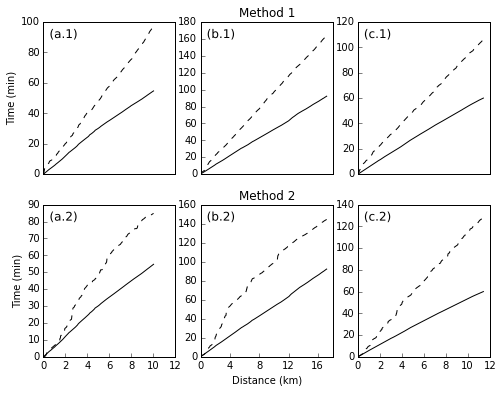

In [43]:
# REAL TIME VS PREDICTED TIME
fig = plt.figure(figsize=(8,6), dpi=72)
method1 = fig.add_subplot(211)
divider = make_axes_locatable(method1)
ax2 = divider.new_horizontal(size="100%", pad=0.35)
ax3 = divider.new_horizontal(size="100%", pad=0.35)

fig1 = method1.get_figure()
fig1.add_axes(ax2)
fig1.add_axes(ax3)

method1.plot(feelingBad1['Distance']/1000, feelingBad1['Time Runner']/60, 'k', label='Race time')
method1.plot(feelingBad1['Distance']/1000, feelingBad1['Total predicted']/60, 'k--', label='Predicted time')
ax2.plot(moratFribourg1['Distance']/1000, moratFribourg1['Time Runner']/60, 'k', label='Race time')
ax2.plot(moratFribourg1['Distance']/1000, moratFribourg1['Total predicted']/60, 'k--', label='Predicted time')
ax3.plot(test1['Distance']/1000, test1['Time Runner']/60, 'k', label='Race time')
ax3.plot(test1['Distance']/1000, test1['Total predicted']/60, 'k--', label='Predicted time')
method1.set_ylabel('Time (min)')
for ax, im_title in zip([method1, ax2, ax3], ["(a.1)", "(b.1)", "(c.1)"]):
        t = add_inner_title(ax, im_title, loc=2)
        t.patch.set_ec("none")
        t.patch.set_alpha(0.5)
        ax.set_xticks([])
        ax.get_yaxis().tick_left()
ax2.set_xticks(ax2.get_xticks()[::2])
ax2.set_title('Method 1')

method2 = fig.add_subplot(212)
divider = make_axes_locatable(method2)
ax2 = divider.new_horizontal(size="100%", pad=0.35)
ax3 = divider.new_horizontal(size="100%", pad=0.35)

fig2 = method2.get_figure()
fig2.add_axes(ax2)
fig2.add_axes(ax3)

method2.plot(feelingBad2['Distance']/1000, feelingBad2['Time Runner']/60, 'k', label='Race time')
method2.plot(feelingBad2['Distance']/1000, feelingBad2['Total predicted']/60, 'k--', label='Predicted time')
ax2.plot(moratFribourg2['Distance']/1000, moratFribourg2['Time Runner']/60, 'k', label='Race time')
ax2.plot(moratFribourg2['Distance']/1000, moratFribourg2['Total predicted']/60, 'k--', label='Predicted time')
ax3.plot(test2['Distance']/1000, test2['Time Runner']/60, 'k', label='Race time')
ax3.plot(test2['Distance']/1000, test2['Total predicted']/60, 'k--', label='Predicted time')
method2.set_ylabel('Time (min)')

for ax, im_title in zip([method2, ax2, ax3], ["(a.2)", "(b.2)", "(c.2)"]):
        t = add_inner_title(ax, im_title, loc=2)
        t.patch.set_ec("none")
        t.patch.set_alpha(0.5)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
ax2.set_xticks(ax2.get_xticks()[::2])
ax2.set_title('Method 2')
ax2.set_xlabel('Distance (km)')

plt.draw()
plt.show()
if len(Datasets_all) == 7:
    fig.savefig('../../../Thesis/images/TimeRunnerVsTimePredictedCS6_Filtered.pdf',bbox_inches='tight', dpi=fig.dpi)
else:
    fig.savefig('../../../Thesis/images/TimeRunnerVsTimePredictedCS6_All.pdf',bbox_inches='tight', dpi=fig.dpi) 

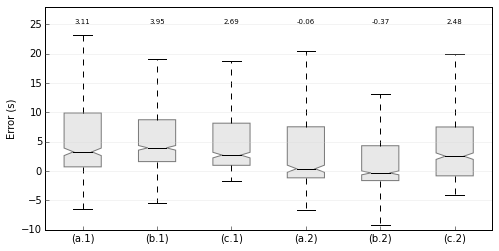

In [45]:
# BOXPLOTS ERRORES DE PREDICCIÓN
errorFeelingBad1 = feelingBad1['$\Delta{}t^{est}$'] - feelingBad1['$\Delta{}t^{real}$']
errorMoratFrib1 = moratFribourg1['$\Delta{}t^{est}$'] - moratFribourg1['$\Delta{}t^{real}$'] 
errorTest1 = test1['$\Delta{}t^{est}$'] - test1['$\Delta{}t^{real}$']
errorFeelingBad2 = feelingBad2['$\Delta{}t^{est}$'] - feelingBad2['$\Delta{}t^{real}$']
errorMoratFrib2 = moratFribourg2['$\Delta{}t^{est}$'] - moratFribourg2['$\Delta{}t^{real}$'] 
errorTest2 = test2['$\Delta{}t^{est}$'] - test2['$\Delta{}t^{real}$']

errors = [errorFeelingBad1, errorMoratFrib1, errorTest1,
          errorFeelingBad2, errorMoratFrib2, errorTest2]
numBoxes = len(errors)
pos = np.arange(numBoxes)+1

fig = plt.figure(figsize=(8,4), dpi=72)
ax = fig.add_subplot(111)
bp = ax.boxplot(errors, labels=['(a.1)', '(b.1)', '(c.1)', '(a.2)', '(b.2)', '(c.2)'], patch_artist=True, sym='', notch=True)

plt.setp(bp['boxes'], color='black', facecolor = 'lightgrey', alpha=0.5)
plt.setp(bp['medians'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['caps'], color='black')
ax.set_ylim([-10, 28])
top = ax.get_ylim()[1]*0.9
medians = [np.nanmedian(i) for i in errors]
upperLabels = [str(np.round(s, 2)) for s in medians]

for tick,label in zip(range(numBoxes),ax.get_xticklabels()):
    ax.text(pos[tick], top, upperLabels[tick], horizontalalignment='center', size='x-small', color='black')

ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.set_ylabel('Error (s)')
if len(Datasets_all) == 7:
    fig.savefig('../../../Thesis/images/bxplotErrorsCS6_Filterd.pdf',bbox_inches='tight', dpi=fig.dpi)
else:
    fig.savefig('../../../Thesis/images/bxplotErrorsCS6_All.pdf',bbox_inches='tight', dpi=fig.dpi)

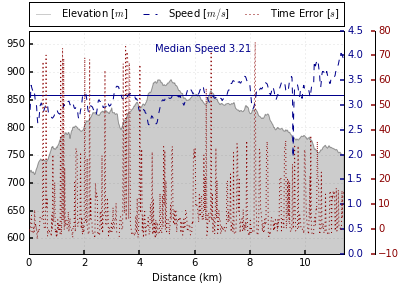

In [50]:
# ELEVATION, HRF & ESTIMATED TIME ERRROR
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.itervalues():
        sp.set_visible(False)
        
fig, host = plt.subplots(figsize=(7,4), dpi=72)
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

par2.spines["right"].set_position(("axes", 1.1))
make_patch_spines_invisible(par2)
par2.spines["right"].set_visible(True)

p1, = host.plot(test2['Distance'], test2['Elevation'], color='k', label='Elevation ['r'$m$]',alpha=0.2)
host.fill_between(test2['Distance'], 0, test2['Elevation'], color='k', alpha=0.2)
p2, = par1.plot(test2['Distance'], test2['Speed'], color='DarkBlue', linestyle='--', label='Speed ['r'$m/s$]')
p2.axes.axhline(y=training_data.speed.median(), color='DarkBlue')
p3, = par2.plot(test2['Distance'], test2['$\Delta{}t^{est}$'] - test2['$\Delta{}t^{real}$'], color='DarkRed', 
                linestyle=':', label=r'Time Error [$s$]')
host.set_xlim([test2['Distance'].min(), test2['Distance'].max()])
host.set_xticklabels([np.str(int(i)) for i in host.get_xticks()/1000])
host.set_ylim([test2['Elevation'].min()*0.8, test2['Elevation'].max()*1.1])

host.set_xlabel(r'Distance (km)')

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
host.tick_params(axis='x', **tkw)
host.get_xaxis().tick_bottom()

host.legend((p1, p2, p3),(p1.get_label(), p2.get_label(), p3.get_label()),
           bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.,
            fontsize=10)
host.grid(alpha=0.25)
host.text(0.4*host.get_xlim()[-1],0.96*host.get_ylim()[-1],
          'Median Speed {:.2f}'.format(training_data.speed.median()), color='DarkBlue', fontsize=10)
fig.savefig("../../../Thesis/images/errorCS6Test_Method2_All.pdf", bbox_inches='tight', dpi=fig.dpi)